In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import multiprocessing as mp
from functools import partial

from sklearn.preprocessing import StandardScaler, RobustScaler

from glob import glob
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [67]:
obdir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/'

In [68]:
min_slr, max_slr = 0, 50
max_T, Tlevel = 0 + 273.15, 650
min_swe_in = 0

# 'keep' will override if any listed, else 'drop'
trim_type = ['min', 'max']
use_surface = False

# NUTAH group use 750 mb, BNSF use 750?
min_level, max_level = 200, 750

keep_key_types = ['T']#, 'Q', 'SPD']# 'VO', 'Z', 'DIR', 'U', 'V', 'R'
drop_key_types = []

# group_label, site_list, interval = 'BNSF24', ['BSNFEX', 'BSNFJE', 'BSNFDC'], 24
group_label, site_list, interval = 'NUTAH12', ['CLNX', 'AGD', 'ALTA', 'BCC', 'SLB', 'PVC'], 12
# group_label, site_list, interval = 'NUTAH24', ['CLNX', 'AGD', 'ALTA', 'BCC', 'SLB', 'PVC'], 24

flist = np.hstack([glob('%scombined/%s*%dh*.pd'%(obdir, site, interval)) for site in site_list])
flist

array(['/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/CLNX_1999_2019.12h.isobaric.pd',
       '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/AGD_2004_2019.12h.isobaric.pd',
       '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/BCC_2004_2019.12h.isobaric.pd',
       '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/PVC_2006_2019.12h.isobaric.pd'],
      dtype='<U113')

In [69]:
df = pd.concat([pd.read_pickle(f) for f in flist])

# Trim out the mins and max if desired, can keep by removing from trim list
trim_keys = [[k for k in df.keys() if ttype in k] for ttype in trim_type]
df = df.drop(columns=np.hstack(trim_keys))

# Rename mean keys to core variable id
rename_keys = {k:k.replace('_mean', '') for k in df.keys()}
df = df.rename(columns=rename_keys)

# Unlabel the time index, relabel as day of year?
doy = [int(pd.to_datetime(d).strftime('%j')) for d in df.index]
df.insert(0, 'day_of_year', doy)

# Clean up the df indexes
df = df.reset_index().drop(columns='time')
df = df.set_index('day_of_year').sort_index().reset_index()
print('uncut:', df.shape)

# Threshold out the events before dropping any keys
df = df[df['slr'] >= min_slr]
df = df[df['slr'] <= max_slr]
print('slr cut (%d, %d):'%(min_slr, max_slr), df.shape)

df = df[df['T_%s'%Tlevel] <= max_T]
print('t cut (%.2f C, %d mb):'%(max_T-273.15, Tlevel), df.shape)

df = df[df['swe_mm'] >= min_swe_in*25.4]
print('swe cut (%s"):'%min_swe_in, df.shape)

# Keep some/drop selected keys
drop_keys, keep_keys = [], ['slr', 'swe_mm']
for k in df.keys():
    try:
        int(k.split('_')[1])
    except:
        check_key = k.split('1')[0]
    else:
        check_key = k.split('_')[0]

    if check_key in drop_key_types:
        drop_keys.append(k)

    elif check_key in keep_key_types:
        keep_keys.append(k)

if len(keep_key_types) > 0:
    df = df[keep_keys]
    
elif len(drop_key_types) > 0:
    df = df.drop(columns=drop_keys)

# Prune vertical levels
keep_keys = ['slr', 'swe_mm']
for k in df.keys():
    try:
        check_level = int(k.split('_')[1])
    except:
        check_level = -1
    
    if (check_level >= min_level) & (check_level <= max_level):
        keep_keys.append(k)
        
    elif use_surface & (check_level == -1):
        keep_keys.append(k)
        
df = df[keep_keys]

uncut: (4000, 207)
slr cut (0, 50): (3999, 207)
t cut (0.00 C, 650 mb): (3943, 207)
swe cut (0"): (3943, 207)


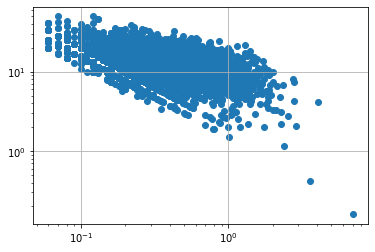

In [70]:
from sklearn.metrics import r2_score

plt.scatter(df['swe_mm']/25.4, df['slr'])
plt.grid()
plt.xscale('log')
plt.yscale('log')

# r2_score(df['slr'], df['swe_mm']/25.4, )

In [71]:
def pairplot(plot_key, plot_data, label):

    plot_keys = np.append(['slr', 'swe_mm'],
                          [k for k in plot_data.keys() if plot_key in k])
    
    plt.rcParams.update({'font.size': 14})
    sns.set_style('darkgrid')
    sns.pairplot(df[plot_keys])

    plt.savefig('./figs/%s_%s_pairplot.png'%(label, plot_key))
    plt.close()
    
    return None

pairplot_mp = partial(pairplot, plot_data=df, label=group_label)

# with mp.get_context('fork').Pool(len(keep_key_types)) as p:
#     p.map(pairplot_mp, keep_key_types, chunksize=1)
#     p.close()
#     p.join()

In [72]:
# Remove SWE after plotting if not using as a predictor
df.pop('swe_mm');

In [73]:
# int(slr) for stratification (> 1 ct per class label)
df = df.dropna()
fac = 10
slr_strata = np.round(df['slr']/fac, 0)*fac
slr_strata.value_counts()

10.0    2326
20.0    1277
30.0     186
0.0      131
40.0      19
50.0       4
Name: slr, dtype: int64

In [74]:
# Split into train/test sets
train_size, test_size, random_state = None, 0.33, 5
X_train, X_test = train_test_split(df, 
                                       test_size=test_size, train_size=train_size, 
                                       random_state=random_state, stratify=slr_strata)

# Split off the target variable now that TTsplit is done
target = 'slr'
y_train, y_test = X_train.pop(target), X_test.pop(target)

print('Train: {}\nTest: {}\nValidate: {}'.format(X_train.shape[0], X_test.shape[0], None))

view_keys = [k+'_500' for k in keep_key_types]
train_stats = X_train[view_keys].describe().T
train_stats

Train: 2641
Test: 1302
Validate: None


,count,mean,std,min,25%,50%,75%,max
T_500,2641.0,250.564896,4.433909,235.236252,247.871399,251.012299,253.885345,263.216187


In [75]:
scaler = StandardScaler().fit(X_train)
# scaler = RobustScaler(quantile_range=(25, 75)).fit(X_train)

X_train_norm = pd.DataFrame(scaler.transform(X_train.loc[:, list(X_train.keys())]), columns=X_train.keys())
X_test_norm = pd.DataFrame(scaler.transform(X_test.loc[:, list(X_train.keys())]), columns=X_train.keys())

X_train_norm[view_keys].describe().T.head(10)

,count,mean,std,min,25%,50%,75%,max
T_500,2641.0,2.166621e-09,1.000189,-3.457794,-0.607592,0.100924,0.749018,2.853845


In [76]:
# Poke around some data here
plt.figure(figsize=(50, 8), facecolor='w')
plt.scatter(np.log(X_train['swe_mm']), np.log(y_train),  c=X_train['T_650'])
plt.colorbar()
plt.grid()
plt.show()

# r2_score(np.log(np.log(y_train), X_train['swe_mm']))

KeyError: 'swe_mm'

<Figure size 3600x576 with 0 Axes>

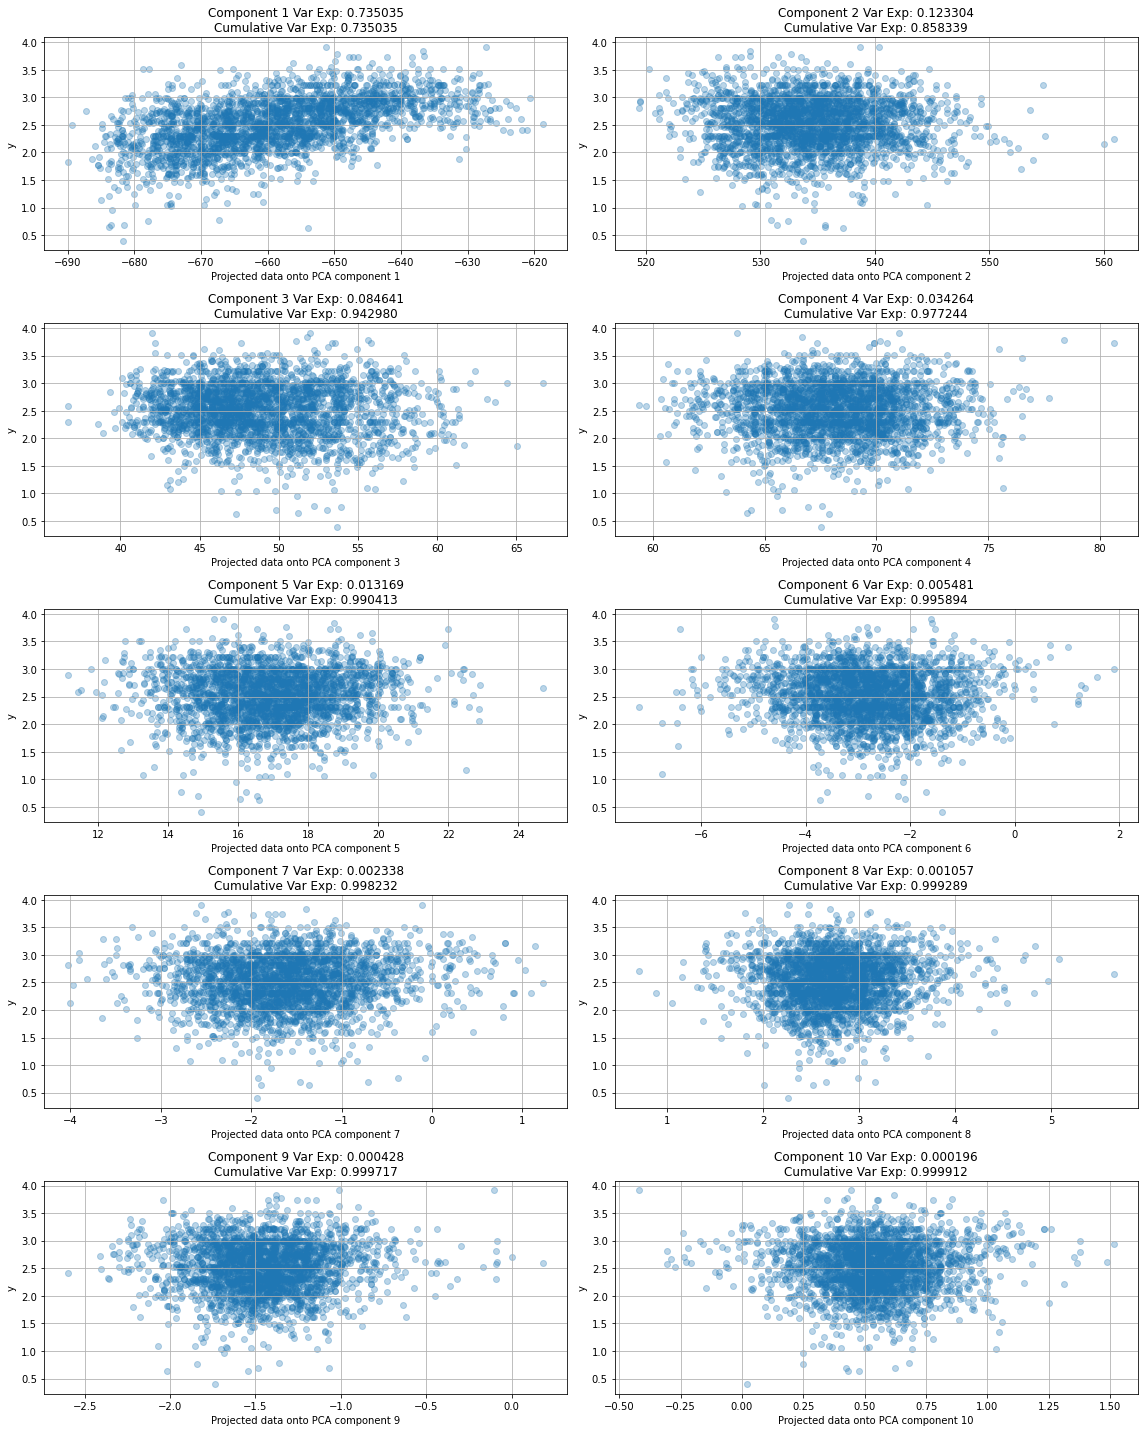

In [78]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10).fit(X_train)

fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.flatten()

for i, ax in enumerate(axes):
    
    ax.set_title('Component %d Var Exp: %f\nCumulative Var Exp: %f'%(
        i+1, pca.explained_variance_ratio_[i], pca.explained_variance_ratio_[:i+1].sum()))
    
    ax.scatter(X_train.dot(pca.components_[i]), np.log(y_train), alpha=.3)
    ax.set(xlabel='Projected data onto PCA component %d'%(i+1), ylabel='y')
    ax.grid()
    
plt.tight_layout()
plt.show()

In [79]:
import scipy.stats

(scipy.stats.pearsonr(X_train_norm.dot(pca.components_[0]), np.log(y_train))[0])**2

0.27400717197251045

In [80]:
for i, j in zip(X_train.keys(), pca.components_[0]):
    print(i, j)

T_200 0.29719216
T_250 0.09675093
T_300 -0.13468747
T_350 -0.2650788
T_400 -0.31604055
T_450 -0.33116084
T_500 -0.3307642
T_550 -0.32386076
T_600 -0.31677195
T_650 -0.3135206
T_700 -0.31144044
T_750 -0.3073011


Text(0.5, 0, 'PC3')

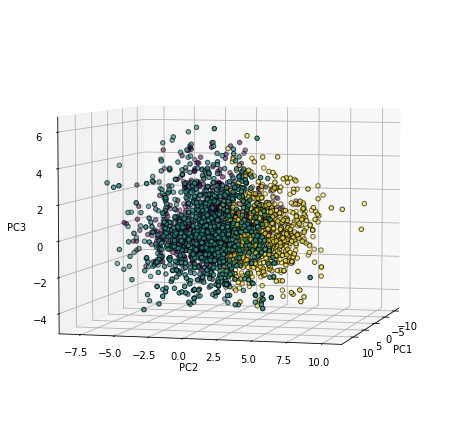

In [47]:
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

comp = [X_train_norm.dot(pca.components_[i]).rename('PC%d'%i) for i in range(3)]
comp = pd.DataFrame(comp).T.values

kmeans = KMeans(n_clusters=3).fit(comp)
labels = kmeans.labels_

fig = plt.figure(0, figsize=(8, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=5, azim=15)

ax.scatter(comp[:, 0], comp[:, 1], comp[:, 2],
               c=labels.astype(float), edgecolor='k')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

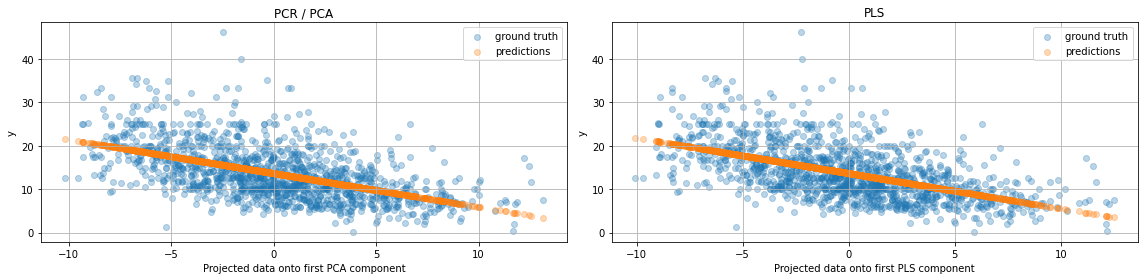

PCR r-squared 0.299
PLS r-squared 0.318
PCR r-squared with 5 components 0.318
PCR r-squared with 10 components 0.378


In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression

pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train_norm, y_train)
pca = pcr.named_steps['pca']  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components=1)
pls.fit(X_train_norm, y_train)

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].scatter(pca.transform(X_test_norm), y_test, alpha=.3, label='ground truth')
axes[0].scatter(pca.transform(X_test_norm), pcr.predict(X_test_norm), alpha=.3,
                label='predictions')
axes[0].set(xlabel='Projected data onto first PCA component',
            ylabel='y', title='PCR / PCA')
axes[0].legend()

axes[1].scatter(pls.transform(X_test_norm), y_test, alpha=.3, label='ground truth')
axes[1].scatter(pls.transform(X_test_norm), pls.predict(X_test_norm), alpha=.3,
                label='predictions')
axes[1].set(xlabel='Projected data onto first PLS component',
            ylabel='y', title='PLS')
axes[1].legend()
[ax.grid() for ax in axes]

plt.tight_layout()
plt.show()

print(f"PCR r-squared {pcr.score(X_test_norm, y_test):.3f}")
print(f"PLS r-squared {pls.score(X_test_norm, y_test):.3f}")

pca_2 = make_pipeline(PCA(n_components=5), LinearRegression())
pca_2.fit(X_train_norm, y_train)
print(f"PCR r-squared with 5 components {pca_2.score(X_test_norm, y_test):.3f}")

pca_2 = make_pipeline(PCA(n_components=10), LinearRegression())
pca_2.fit(X_train_norm, y_train)
print(f"PCR r-squared with 10 components {pca_2.score(X_test_norm, y_test):.3f}")



Linear Regression Train Score: 0.386
Linear Regression Test Score: 0.400


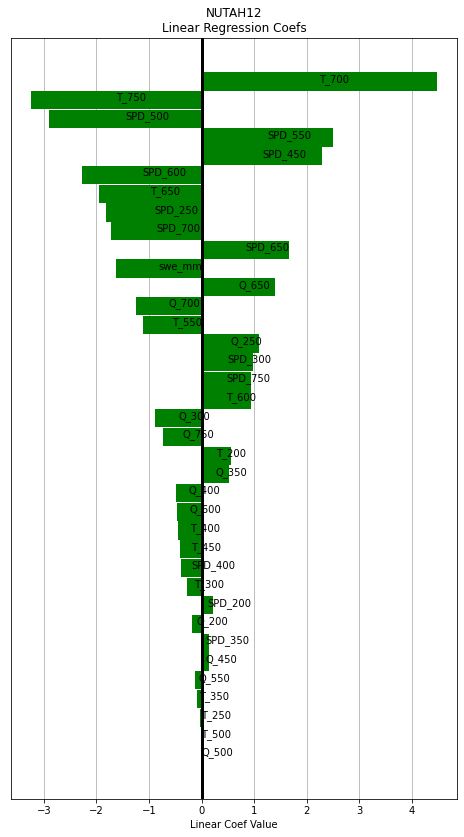

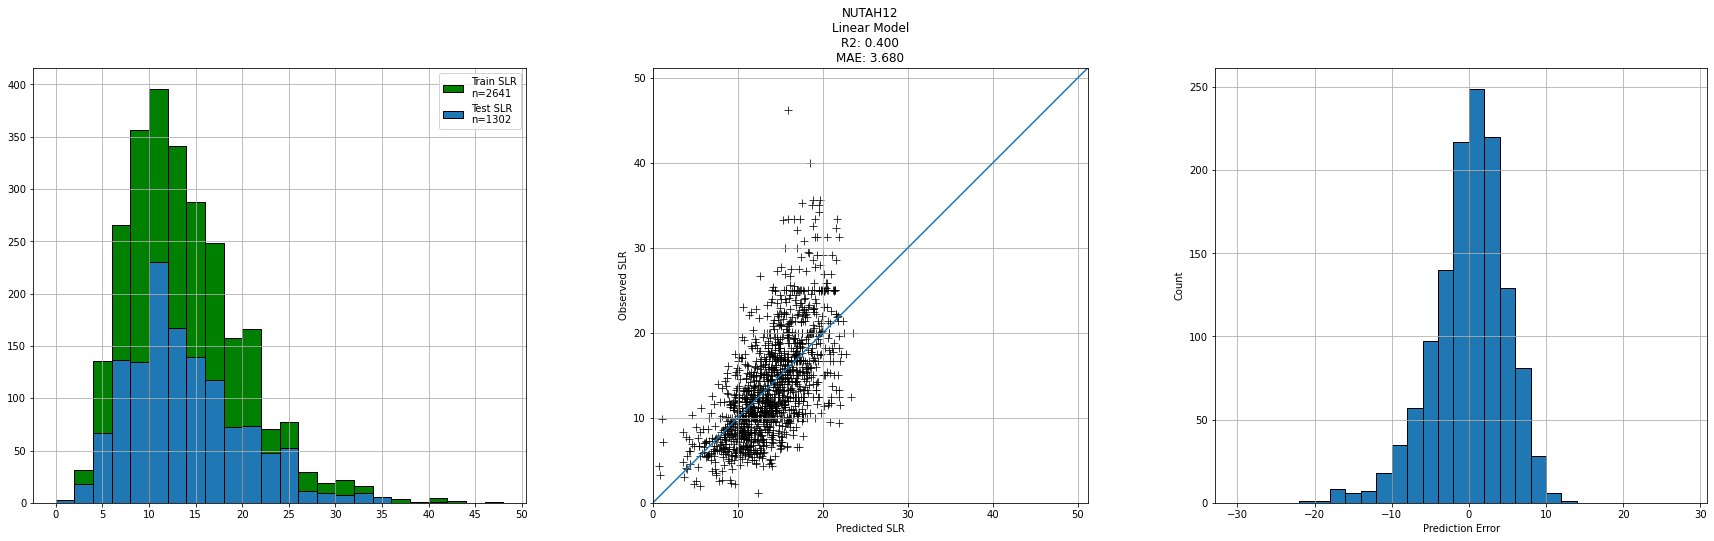

In [17]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_norm, y_train)

lr_train_score = lr.score(X_train_norm, y_train)
lr_test_score = lr.score(X_test_norm, y_test)

print('Linear Regression Train Score: %.3f'%lr_train_score)
print('Linear Regression Test Score: %.3f'%lr_test_score)

fig, ax = plt.subplots(1, 1, facecolor='w', figsize=(8, 14))

ranksort = np.argsort(abs(lr.coef_))[::-1]
lr_coefs = lr.coef_[ranksort]
lr_keys = X_train_norm.keys()[ranksort]
mask = lr_coefs != 0

ax.axvline(0, color='k', linewidth=3, zorder=11)
ax.barh(lr_keys[mask], lr_coefs[mask], color='green', zorder=10, height=0.97)

for i, k in enumerate(lr_keys[mask]):
    if lr_coefs[i] != 0:
        ax.text(lr_coefs[i]/2, k, k, zorder=20)

ax.invert_yaxis()
ax.axes.get_yaxis().set_visible(False)
ax.set_title('%s\nLinear Regression Coefs'%group_label)
ax.set_xlabel('Linear Coef Value')
ax.grid(zorder=-1)
plt.show()

test_predictions = lr.predict(X_test_norm)
lr_mae = np.nanmean(abs(test_predictions - y_test))

maxslr = test_predictions.max() if test_predictions.max() > y_test.max() else y_test.max()
maxslr += 5

fig, axs = plt.subplots(1, 3, figsize=(30, 8), facecolor='w')

ax = axs[0]
maxslr = y_test.max() if y_test.max() > y_train.max() else y_train.max()

ax.hist(y_train, bins=np.arange(0, maxslr, 2), color='g', edgecolor='k', alpha=1.0, label='Train SLR\nn=%d'%len(y_train))
ax.hist(y_test, bins=np.arange(0, maxslr, 2), color='C0', edgecolor='k', alpha=1.0, label='Test SLR\nn=%d'%len(y_test))
ax.legend()

ax.set_xticks(np.arange(0, maxslr+1, 5))
ax.set_xticklabels(np.arange(0, maxslr+1, 5).astype(int))
ax.grid()

ax = axs[1]
maxslr = test_predictions.max() if test_predictions.max() > y_test.max() else y_test.max()
maxslr += 5
ax.scatter(test_predictions, y_test, c='k', s=50, marker='+', linewidth=0.75)
ax.set_ylabel('Observed SLR')
ax.set_xlabel('Predicted SLR')
ax.plot([0, maxslr], [0, maxslr])
ax.set_xlim([0, maxslr])
ax.set_ylim([0, maxslr])
ax.set_aspect('equal')
ax.grid()
axs[1].set_title('%s\nLinear Model\nR2: %.3f\nMAE: %.3f'%(
    group_label, lr_test_score, lr_mae))

ax = axs[2]
error = test_predictions - y_test
ax.hist(error, bins=np.arange(-30, 30, 2), edgecolor='k')
ax.set_xlabel('Prediction Error')
ax.set_ylabel('Count')
ax.grid()

# fig.suptitle('MultiLayer Perceptron (Simple ANN) [%d Hidden Layer Sizes]'%layer_sizes)

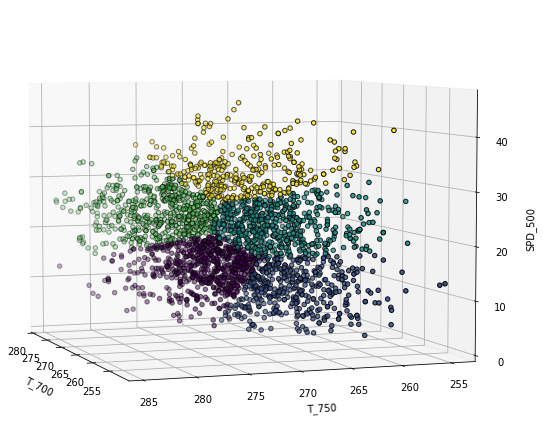

In [18]:
#'T_650', 'SPD_600', 'swe_mm' # Alcott top 3
var1, var2, var3 = lr_keys[mask][:3]

comp = [X_train[var1], X_train[var2], X_train[var3]]
comp = pd.DataFrame(comp).T.values

kmeans = KMeans(n_clusters=5).fit(comp)
labels = kmeans.labels_

fig = plt.figure(0, figsize=(8, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=5, azim=160)

ax.scatter(comp[:, 0], comp[:, 1], comp[:, 2],
               c=labels.astype(float), edgecolor='k')

ax.set_xlabel(var1)
ax.set_ylabel(var2)
ax.set_zlabel(var3)

ax.dist = 8

Elastic Train Score: 0.384
Elastic Test Score: 0.401


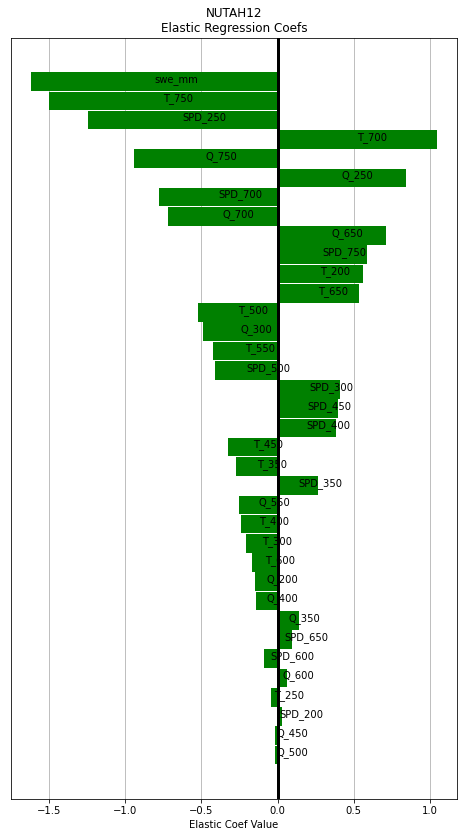

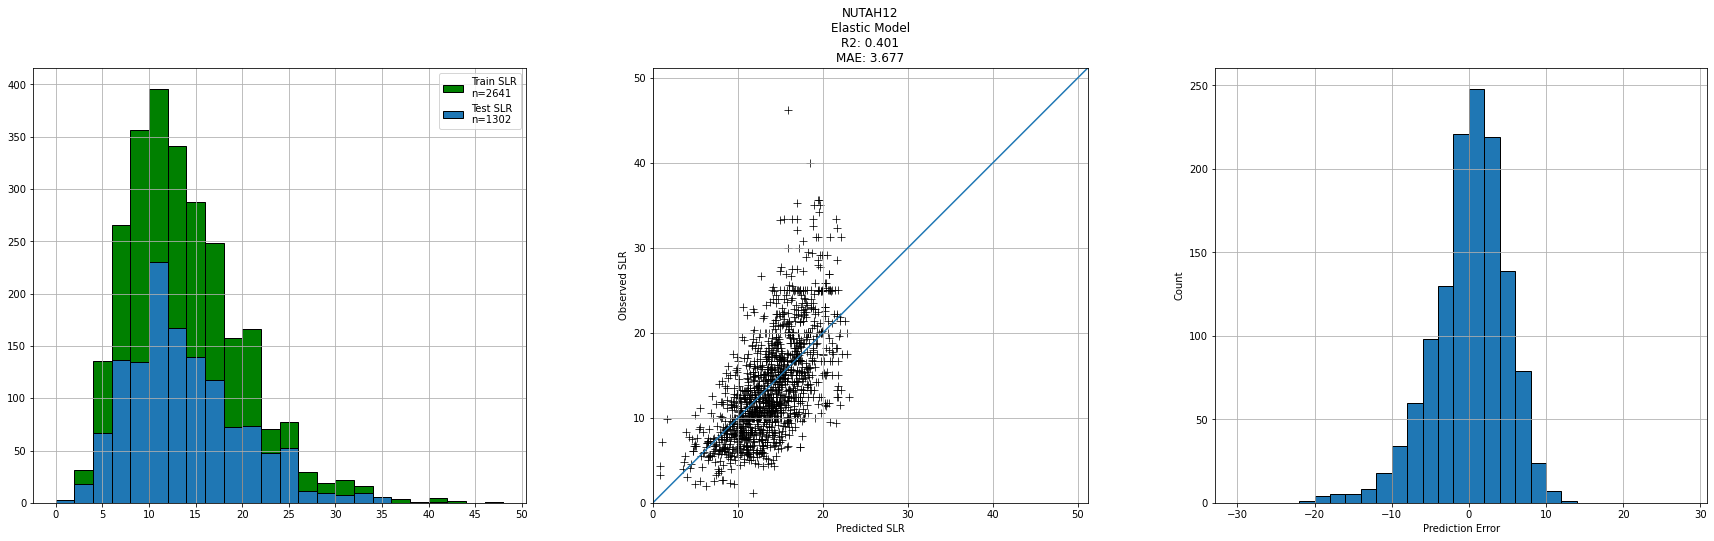

In [51]:
from sklearn.linear_model import ElasticNet

# Grid-search for best parameters? (alpha and l1_ratio)

elastic = ElasticNet(alpha=0.009, l1_ratio=0.1, max_iter=10e5)
elastic.fit(X_train_norm, y_train)

elastic_train_score = elastic.score(X_train_norm, y_train)
elastic_test_score = elastic.score(X_test_norm, y_test)
elastic_coeff_used = np.sum(elastic.coef_ != 0)
    
print('Elastic Train Score: %.3f'%elastic_train_score)
print('Elastic Test Score: %.3f'%elastic_test_score)

fig, ax = plt.subplots(1, 1, facecolor='w', figsize=(8, 14))

ranksort = np.argsort(abs(elastic.coef_))[::-1]
elastic_coefs = elastic.coef_[ranksort]
elastic_keys = X_train_norm.keys()[ranksort]
mask = elastic_coefs != 0

ax.axvline(0, color='k', linewidth=3, zorder=11)
ax.barh(elastic_keys[mask], elastic_coefs[mask], color='green', zorder=10, height=0.97)

for i, k in enumerate(elastic_keys[mask]):
    if elastic_coefs[i] != 0:
        ax.text(elastic_coefs[i]/2, k, k, zorder=20)

ax.invert_yaxis()
ax.axes.get_yaxis().set_visible(False)
ax.set_title('%s\nElastic Regression Coefs'%group_label)
ax.set_xlabel('Elastic Coef Value')
ax.grid(zorder=-1)
plt.show()

test_predictions = elastic.predict(X_test_norm)
elastic_mae = np.nanmean(abs(test_predictions - y_test))

maxslr = test_predictions.max() if test_predictions.max() > y_test.max() else y_test.max()
maxslr += 5

fig, axs = plt.subplots(1, 3, figsize=(30, 8), facecolor='w')

ax = axs[0]
maxslr = y_test.max() if y_test.max() > y_train.max() else y_train.max()

ax.hist(y_train, bins=np.arange(0, maxslr, 2), color='g', edgecolor='k', alpha=1.0, label='Train SLR\nn=%d'%len(y_train))
ax.hist(y_test, bins=np.arange(0, maxslr, 2), color='C0', edgecolor='k', alpha=1.0, label='Test SLR\nn=%d'%len(y_test))
ax.legend()

ax.set_xticks(np.arange(0, maxslr+1, 5))
ax.set_xticklabels(np.arange(0, maxslr+1, 5).astype(int))
ax.grid()

ax = axs[1]
maxslr = test_predictions.max() if test_predictions.max() > y_test.max() else y_test.max()
maxslr += 5
ax.scatter(test_predictions, y_test, c='k', s=50, marker='+', linewidth=0.75)
ax.set_ylabel('Observed SLR')
ax.set_xlabel('Predicted SLR')
ax.plot([0, maxslr], [0, maxslr])
ax.set_xlim([0, maxslr])
ax.set_ylim([0, maxslr])
ax.set_aspect('equal')
ax.grid()
axs[1].set_title('%s\nElastic Model\nR2: %.3f\nMAE: %.3f'%(group_label, elastic_test_score, elastic_mae))

ax = axs[2]
error = test_predictions - y_test
ax.hist(error, bins=np.arange(-30, 30, 2), edgecolor='k')
ax.set_xlabel('Prediction Error')
ax.set_ylabel('Count')
ax.grid()
plt.show()

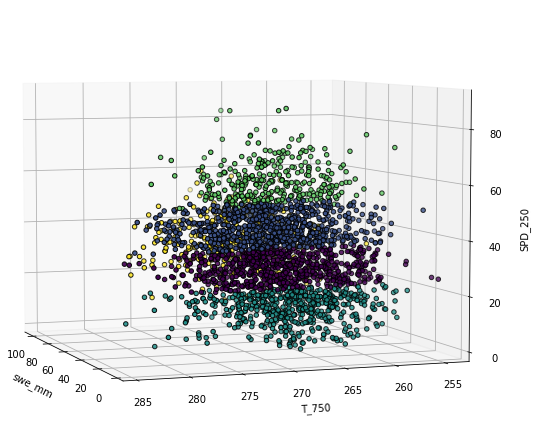

In [20]:
#'T_650', 'SPD_600', 'swe_mm' # Alcott top 3
var1, var2, var3 = elastic_keys[mask][:3]

comp = [X_train[var1], X_train[var2], X_train[var3]]
comp = pd.DataFrame(comp).T.values

kmeans = KMeans(n_clusters=5).fit(comp)
labels = kmeans.labels_

fig = plt.figure(0, figsize=(8, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=5, azim=160)

ax.scatter(comp[:, 0], comp[:, 1], comp[:, 2],
               c=labels.astype(float), edgecolor='k')

ax.set_xlabel(var1)
ax.set_ylabel(var2)
ax.set_zlabel(var3)

ax.dist = 8

MLP Train Score: 0.530
MLP Test Score: 0.455



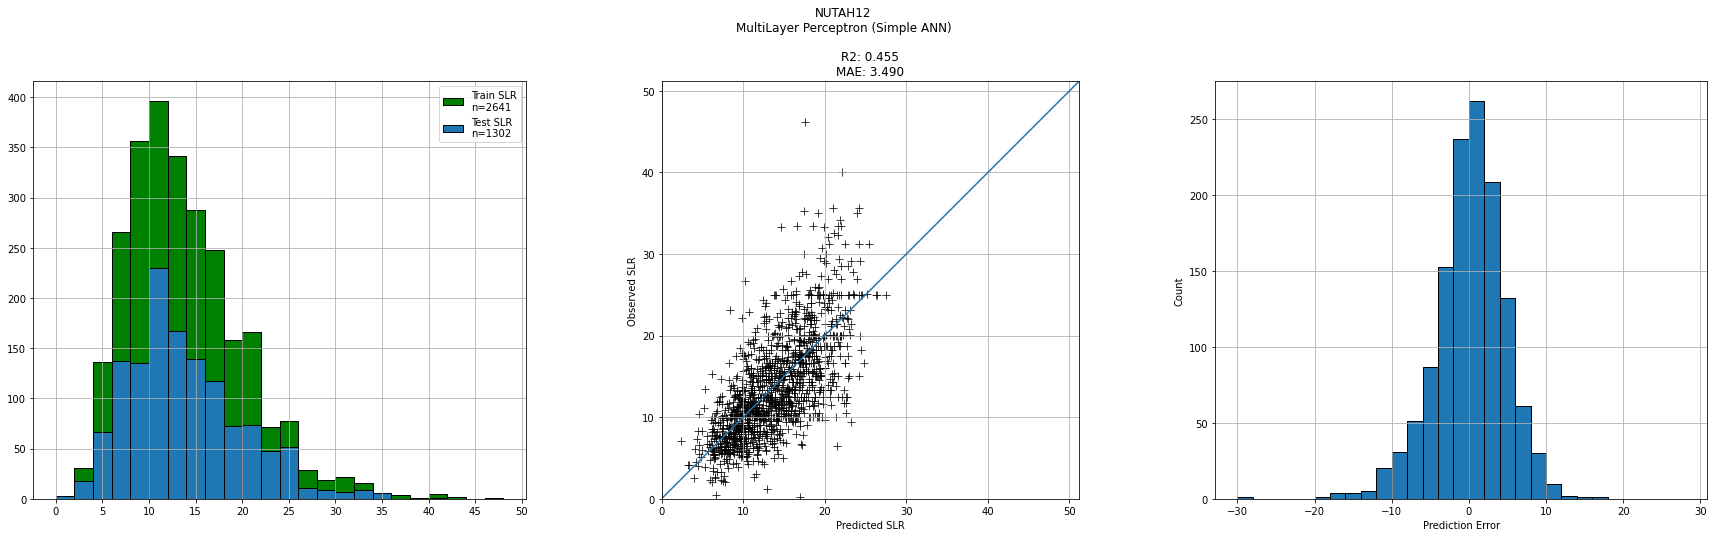

In [21]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(
#     hidden_layer_sizes=(10,), 
#     activation='relu', 
#     solver='sgd', 
#     alpha=0.00001, 
#     batch_size='auto', 
#     learning_rate='adaptive', 
#     learning_rate_init=0.0001, 
#     power_t=0.5, 
#     max_iter=50000, 
#     shuffle=True, 
#     random_state=random_state, 
#     tol=0.0001, 
#     verbose=False, 
#     warm_start=True, 
#     momentum=0.7, 
#     nesterovs_momentum=True, 
#     early_stopping=True, 
#     validation_fraction=0.4, 
#     beta_1=0.5, 
#     beta_2=0.999, 
#     epsilon=1e-8
)

mlp.fit(X_train_norm, y_train)

mlp_train_score = mlp.score(X_train_norm, y_train)
mlp_test_score = mlp.score(X_test_norm, y_test)

print('MLP Train Score: %.3f'%mlp_train_score)
print('MLP Test Score: %.3f'%mlp_test_score)
print()

test_predictions = mlp.predict(X_test_norm)
mlp_mae = np.nanmean(abs(test_predictions - y_test))

maxslr = test_predictions.max() if test_predictions.max() > y_test.max() else y_test.max()
maxslr += 5

fig, axs = plt.subplots(1, 3, figsize=(30, 8), facecolor='w')

ax = axs[0]
maxslr = y_test.max() if y_test.max() > y_train.max() else y_train.max()

ax.hist(y_train, bins=np.arange(0, maxslr, 2), color='g', edgecolor='k', alpha=1.0, label='Train SLR\nn=%d'%len(y_train))
ax.hist(y_test, bins=np.arange(0, maxslr, 2), color='C0', edgecolor='k', alpha=1.0, label='Test SLR\nn=%d'%len(y_test))
ax.legend()

ax.set_xticks(np.arange(0, maxslr+1, 5))
ax.set_xticklabels(np.arange(0, maxslr+1, 5).astype(int))
ax.grid()

ax = axs[1]
maxslr = test_predictions.max() if test_predictions.max() > y_test.max() else y_test.max()
maxslr += 5
ax.scatter(test_predictions, y_test, c='k', s=50, marker='+', linewidth=0.75)
ax.set_ylabel('Observed SLR')
ax.set_xlabel('Predicted SLR')
ax.plot([0, maxslr], [0, maxslr])
ax.set_xlim([0, maxslr])
ax.set_ylim([0, maxslr])
ax.set_aspect('equal')
ax.grid()
axs[1].set_title('R2: %.3f\nMAE: %.3f'%(mlp_test_score, mlp_mae))

ax = axs[2]
error = test_predictions - y_test
ax.hist(error, bins=np.arange(-30, 30, 2), edgecolor='k')
ax.set_xlabel('Prediction Error')
ax.set_ylabel('Count')
ax.grid()

fig.subplots_adjust(top=.85)
fig.suptitle('%s\nMultiLayer Perceptron (Simple ANN)'%(group_label))
plt.show()

In [ ]:
from sklearn.svm import SVR

svr = SVR(
#     C=_C, #Ridge regularization parameter for (L2)^2 penalty
#     epsilon=_e, #Specifies the epsilon-tube within which no penalty is associated in the training loss function
#     kernel='rbf', #'linear', 'polynomial', 'rbf'
#     degree=3, #pass interger for 'polynomial' kernel, ignored otherwise
#     tol=0.001, #stopping tolerance
#     shrinking=False, 
#     cache_size=200, 
#     verbose=False
)

svr.fit(X_train_norm, y_train)

svr_train_score = svr.score(X_train_norm, y_train)
svr_test_score = svr.score(X_test_norm, y_test)

print('SVR Train Score: %.3f'%svr_train_score)
print('SVR Test Score: %.3f'%svr_test_score)
print()

test_predictions = svr.predict(X_test_norm)
svr_mae = np.nanmean(abs(test_predictions - y_test))

maxslr = test_predictions.max() if test_predictions.max() > y_test.max() else y_test.max()
maxslr += 5

fig, axs = plt.subplots(1, 3, figsize=(30, 8), facecolor='w')

ax = axs[0]
maxslr = y_test.max() if y_test.max() > y_train.max() else y_train.max()

ax.hist(y_train, bins=np.arange(0, maxslr, 2), color='g', edgecolor='k', alpha=1.0, label='Train SLR\nn=%d'%len(y_train))
ax.hist(y_test, bins=np.arange(0, maxslr, 2), color='C0', edgecolor='k', alpha=1.0, label='Test SLR\nn=%d'%len(y_test))
ax.legend()

ax.set_xticks(np.arange(0, maxslr+1, 5))
ax.set_xticklabels(np.arange(0, maxslr+1, 5).astype(int))
ax.grid()

ax = axs[1]
maxslr = test_predictions.max() if test_predictions.max() > y_test.max() else y_test.max()
maxslr += 5
ax.scatter(test_predictions, y_test, c='k', s=50, marker='+', linewidth=0.75)
ax.set_ylabel('Observed SLR')
ax.set_xlabel('Predicted SLR')
ax.plot([0, maxslr], [0, maxslr])
ax.set_xlim([0, maxslr])
ax.set_ylim([0, maxslr])
ax.set_aspect('equal')
ax.grid()
axs[1].set_title('R2: %.3f\nMAE: %.3f'%(svr_test_score, svr_mae))

ax = axs[2]
error = test_predictions - y_test
ax.hist(error, bins=np.arange(-30, 30, 2), edgecolor='k')
ax.set_xlabel('Prediction Error')
ax.set_ylabel('Count')
ax.grid()

fig.subplots_adjust(top=.85)
fig.suptitle('%s\nSupport Vector Regressor (Simple SVM)'%(group_label))
plt.show()